# Layers

This notebook introduces a set of layers commonly found in CNNs:

- Batch Normalization
- Dropout
- Pooling



## References

### Batch Normalization
- Original paper: Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
Sergey Ioffe, Christian Szegedy
https://arxiv.org/abs/1502.03167

- Video [Why does Batch Norm work?](https://www.youtube.com/watch?v=nUUqwaxLnWs) Andrew Ng

- Tensorflow: 
tf.keras.layers.BatchNormalization
https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

- [A Gentle Introduction to Batch Normalization for Deep Neural Networks](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)

### Dropout
- Original paper: Improving neural networks by preventing co-adaptation of feature detectors (2012)
G. E. Hinton∗ , N. Srivastava, A. Krizhevsky, I. Sutskever and R. R. Salakhutdinov
https://arxiv.org/pdf/1207.0580.pdf

- More evaluation: Dropout: A Simple Way to Prevent Neural Networks from Overfitting (2014)
Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, Ruslan Salakhutdinov
https://jmlr.org/papers/v15/srivastava14a.html

- A Gentler Article: A Gentle Introduction to Dropout for Regularizing Deep Neural Networks (2018)
Jason Brownlee
https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

- Another Gentle Article: Understanding And Implementing Dropout In TensorFlow And Keras
Richmond Alake
https://towardsdatascience.com/understanding-and-implementing-dropout-in-tensorflow-and-keras-a8a3a02c1bfa


### Pooling

- Evaluation of Pooling Operations in Convolutional Architectures for Object Recognition
Dominik Scherer, Andreas Muller, and Sven Behnke
http://ais.uni-bonn.de/papers/icann2010_maxpool.pdf

- An alernative to pooling: Striving for Simplicity: The All Convolutional Net, Jost Tobias Springenberg, Alexey Dosovitskiy, Thomas Brox, Martin Riedmiller, https://arxiv.org/abs/1412.6806

- [A Gentle Introduction to Pooling Layers for Convolutional Neural Networks](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)


### General

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.youtube.com/watch?v=yH1cF7GnoIo    

https://www.datacamp.com/community/tutorials/tensorflow-tutorial    



In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,TensorBoard, EarlyStopping
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, \
            Dense, Activation, Flatten, Dropout, Input

import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import IPython.display as display

import seaborn as sn
import pandas as pd

BATCH_SIZE = 32
IMAGE_SIZE = 32

### Auxiliary functions for display purposes only

In [2]:
def show_batch(cols, image_batch, label_batch):

    rows = int(BATCH_SIZE / cols) 
    if rows * cols < BATCH_SIZE:
        rows += 1
    width = 3 * rows
    height = 3 * cols
    
    
    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()
    for n in range(BATCH_SIZE):
        
        subplot_title=("class "+ classNames[label_batch[n]==1][0])
        axes.ravel()[n].set_title(subplot_title)  
        axes.ravel()[n].imshow(image_batch[n])
        axes.ravel()[n].axis('off')

    fig.tight_layout()    
    plt.show()
    
    
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['simple', 'new layers']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.70)
    plt.legend(loc='upper left')
    plt.show()


def show_data(s1,l1, s2,l2, labels):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1-00, bottom = 0.70)
    plt.legend(loc='upper left')
    plt.show()


    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()
    

def show_confusion_matrix(model, dataset):
   
    all_labels = []
    all_preds = []

    for images , labels in dataset.take(-1):  
        numpy_labels = labels.numpy()
        numpy_images = images.numpy()
        preds = model.predict(numpy_images, verbose=0)  
        
        all_labels += [np.argmax(x) for x in numpy_labels]
        all_preds += [np.argmax(x) for x in preds]
        
    conf_mat = tf.math.confusion_matrix(all_labels, all_preds)

    df_cm = pd.DataFrame(conf_mat.numpy(), range(8), range(8))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()

    res_correct = {0:0, 1:0, 2:0, 3:0,4:0,5:0,6:0,7:0}
    res_incorrect = {0:0, 1:0, 2:0, 3:0,4:0,5:0,6:0,7:0}
    for i in range(len(all_preds)):
        if all_preds[i] == all_labels[i]:
            res_correct[all_labels[i]] += 1
        else:
            res_incorrect[all_labels[i]] += 1

    for i in range(len(res_correct)):

        print('class: ', i, ' total images: ', res_correct[i] + res_incorrect[i],' % correct: ', res_correct[i] / (res_correct[i] + res_incorrect[i]))

### Auxiliary functions to load images

In [3]:
classNames = np.array(['00000','00001', '00002', '00003', '00004', '00005', '00006', '00007'])

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

## Local Settings

set the paths to the image data and where the model and logs will be saved.

In [4]:
data_path = 'c:/work/vcpi/gtsrb'
log_and_model_path = 'c:/work/vcpi/dl04/'

### Load images

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_listset = tf.data.Dataset.list_files(f'{data_path}/train/*/*.png')
train_set = train_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

val_listset = tf.data.Dataset.list_files(f'{data_path}/val/*/*.png')
val_set = val_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

test_listset = tf.data.Dataset.list_files(f'{data_path}/test/*/*.png')
test_set = test_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

### Print some data and compute dataset length

In [6]:
for image, label in train_set.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

dataset_length = train_set.cardinality().numpy()
print(dataset_length)


Image shape:  (32, 32, 3)
Label:  [False  True False False False False False False]
10200


### Prepare the dataset

In [7]:
train_set = train_set.cache()
train_set = train_set.shuffle(buffer_size=10200)
train_set = train_set.batch(batch_size = BATCH_SIZE)
train_set = train_set.prefetch(buffer_size = AUTOTUNE)

val_set = val_set.cache()
val_set = val_set.batch(batch_size = BATCH_SIZE)
val_set = val_set.prefetch(buffer_size = AUTOTUNE)


### Prepare the test set

In [8]:
test_set = test_set.batch(batch_size = BATCH_SIZE)

testset_length = test_set.cardinality().numpy()
print('Number of batches: ', testset_length)


Number of batches:  131


## Model I - plain (only Conv layers)

### Definition

In [9]:
def model_I(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Input(shape=(imgSize, imgSize, channels)))
    model.add(Conv2D(64, (5, 5)))         
    model.add(LeakyReLU(alpha=0.01))     
                                
    model.add(Conv2D(64, (5, 5) )) 
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (5, 5) ) )   
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))             

    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model


### Create the models and display stats

In [10]:
modelV1 = model_I(8, 32, 3)

print(modelV1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        102464    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 flatten (Flatten)           (None, 25600)             0

c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Callback definition

 - saving model weights at the best epoch considering validation accuracy
 - early stopping when validation accuracy no longer drops for a number of epochs
 - record session to be available on tensorboard.
    
Go to folder where logs are locatted and call >tensorboard --logdir logs

then open a browser and go to:

http://localhost:6006/    

In [11]:
def prepareCallbacks(path):

    file_path = f'{log_and_model_path}/{path}/cp.ckpt'

    checkpointer = ModelCheckpoint(filepath= file_path, 
                                monitor = 'val_accuracy',
                                verbose=1, 
                                save_weights_only=True,
                                save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_accuracy', min_delta = 0.0001, patience = 8, verbose = 1)

    tbCallBack = TensorBoard(log_dir=f'{log_and_model_path}/{path}_log', histogram_freq=0, write_graph=True, write_images=True)

    return file_path, [checkpointer, earlyStopper, tbCallBack]

### Train model

In [12]:
file_pathV1, callbacksM1 = prepareCallbacks('bestM1')

historyV1 = modelV1.fit(train_set,
          epochs=50, 
          validation_data = val_set, 
          callbacks=callbacksM1)

Epoch 1/50
319/319 [==============================] - ETA: 0s - loss: 0.9450 - accuracy: 0.6818
Epoch 1: val_accuracy improved from -inf to 0.86550, saving model to c:/work/vcpi/dl04//bestM1\cp.ckpt
319/319 [==============================] - 9s 12ms/step - loss: 0.9450 - accuracy: 0.6818 - val_loss: 0.4446 - val_accuracy: 0.8655
Epoch 2/50
317/319 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.9427
Epoch 2: val_accuracy did not improve from 0.86550
319/319 [==============================] - 3s 8ms/step - loss: 0.2056 - accuracy: 0.9427 - val_loss: 0.4741 - val_accuracy: 0.8465
Epoch 3/50
316/319 [============================>.] - ETA: 0s - loss: 0.1041 - accuracy: 0.9712
Epoch 3: val_accuracy improved from 0.86550 to 0.89729, saving model to c:/work/vcpi/dl04//bestM1\cp.ckpt
319/319 [==============================] - 3s 9ms/step - loss: 0.1042 - accuracy: 0.9712 - val_loss: 0.3239 - val_accuracy: 0.8973
Epoch 4/50
317/319 [============================>.] - ETA:

### Show graphs for accuracy and loss history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


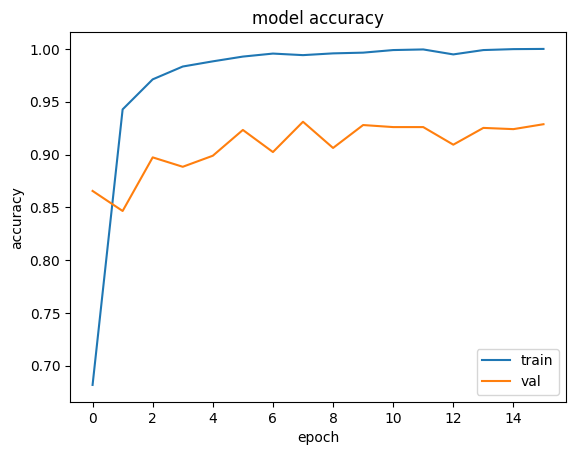

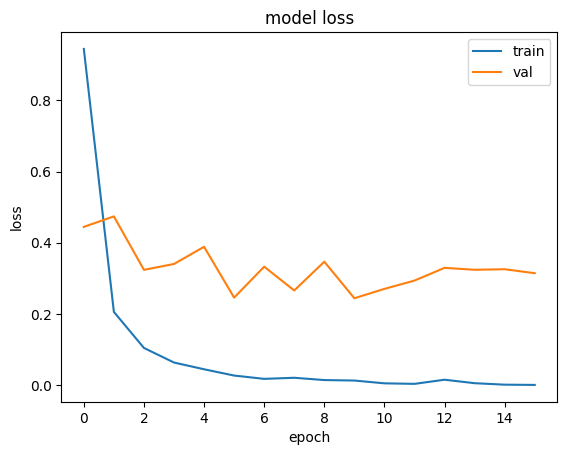

In [13]:
show_history(historyV1)

### Load weights for best epoch and evaluate model

Notice how the validation set accuracy differs from the test set accuracy. Why?

In [14]:
modelV1.load_weights(file_pathV1)

evalV1 = modelV1.evaluate(test_set, verbose=2)
print(evalV1)

valV1 = modelV1.evaluate(val_set, verbose=2)

131/131 - 1s - loss: 0.3340 - accuracy: 0.9400 - 711ms/epoch - 5ms/step
[0.3340015113353729, 0.9400479793548584]
81/81 - 0s - loss: 0.2658 - accuracy: 0.9310 - 240ms/epoch - 3ms/step


## Model II - adding batch norm, dropout, and max pooling

### Definition

In [15]:
def model_II(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Input(shape=(imgSize, imgSize, channels)))

    model.add(Conv2D(64, (5, 5)))         
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    
    model.add(Conv2D(64, (5, 5) )) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5) ) )   
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))             
    model.add(Dropout(0.2))

    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model

### Create the models and display stats

In [16]:
modelV2 = model_II(8, 32, 3)

print(modelV2.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 64)       

### Callback definition

In [17]:
file_pathV2 = f'{log_and_model_path}/best_modelV2/cp.ckpt'

checkpointerV2 = ModelCheckpoint(filepath= file_pathV2, 
                               monitor = 'val_accuracy',
                               verbose = 1, 
                               save_weights_only=True,
                               save_best_only=True)


earlyStopperV2 = EarlyStopping(monitor='val_accuracy', min_delta = 0.0001, patience = 8, verbose = 1)

tbCallBackV2 = TensorBoard(log_dir=f'{log_and_model_path}/logV2', histogram_freq=0, write_graph=True, write_images=True)

### Train model

In [18]:
file_pathV2, callbacksM2 = prepareCallbacks('bestM2')

historyV2 = modelV2.fit(train_set,
          epochs=50, 
          validation_data = val_set, 
          
          callbacks=callbacksM2)

Epoch 1/50
319/319 [==============================] - ETA: 0s - loss: 1.0701 - accuracy: 0.6273
Epoch 1: val_accuracy improved from -inf to 0.27093, saving model to c:/work/vcpi/dl04//bestM2\cp.ckpt
319/319 [==============================] - 3s 9ms/step - loss: 1.0701 - accuracy: 0.6273 - val_loss: 1.5742 - val_accuracy: 0.2709
Epoch 2/50
318/319 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9416
Epoch 2: val_accuracy improved from 0.27093 to 0.83295, saving model to c:/work/vcpi/dl04//bestM2\cp.ckpt
319/319 [==============================] - 3s 8ms/step - loss: 0.2293 - accuracy: 0.9416 - val_loss: 0.5071 - val_accuracy: 0.8329
Epoch 3/50
314/319 [============================>.] - ETA: 0s - loss: 0.0957 - accuracy: 0.9778
Epoch 3: val_accuracy improved from 0.83295 to 0.86667, saving model to c:/work/vcpi/dl04//bestM2\cp.ckpt
319/319 [==============================] - 3s 8ms/step - loss: 0.0954 - accuracy: 0.9777 - val_loss: 0.3493 - val_accuracy: 0.8667
Epoc

### Show graphs for accuracy and loss history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


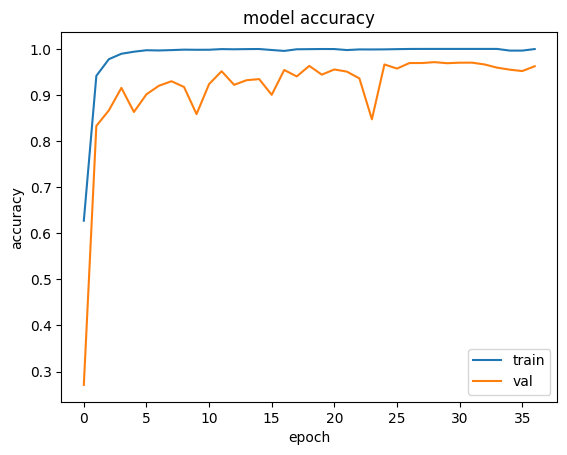

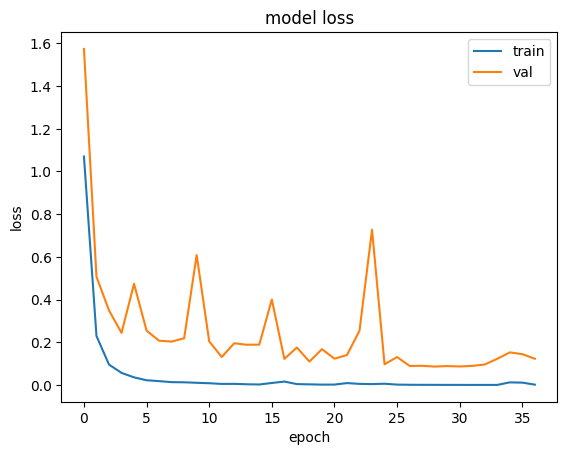

In [19]:
show_history(historyV2)

In [20]:
modelV2.load_weights(file_pathV2)

evalV2 = modelV2.evaluate(test_set, verbose=2)
print(evalV2)
valV2 = modelV2.evaluate(val_set, steps=2580/BATCH_SIZE, verbose=2)

131/131 - 1s - loss: 0.0894 - accuracy: 0.9767 - 728ms/epoch - 6ms/step
[0.0893605425953865, 0.9767386317253113]
80/80 - 0s - loss: 0.0861 - accuracy: 0.9713 - 231ms/epoch - 3ms/step


[0.2658044099807739, 0.9310077428817749] [0.3340015113353729, 0.9400479793548584] [0.08608533442020416, 0.9713178277015686] [0.0893605425953865, 0.9767386317253113]


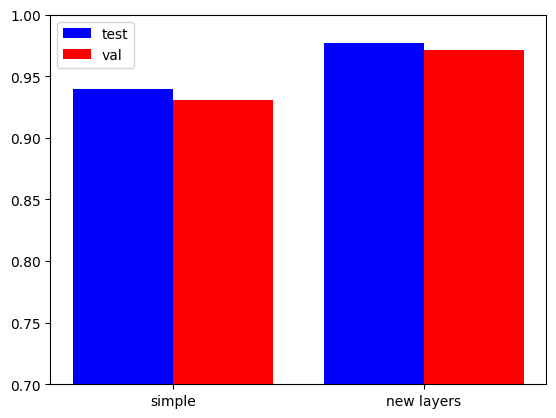

In [21]:
print(valV1, evalV1, valV2, evalV2)

show_accuracies()

## Model III - Larger number of filters

In [22]:
def model_III(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Conv2D(128, (5, 5), 
                     input_shape=(imgSize, imgSize, channels)
                     ))         
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    
    model.add(Conv2D(128, (5, 5) )) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (5, 5) ) )   
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))             
    model.add(Dropout(0.2))

    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model

In [23]:
modelV3 = model_III(8, 32, 3)

print(modelV3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       9728      
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 28, 28, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)       409728    
                                                                 
 batch_normalization_4 (Batc  (None, 24, 24, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 24, 24, 128)      

In [24]:
file_pathV3, callbacksM3 = prepareCallbacks('bestM3')

historyV3 = modelV3.fit(train_set,
          epochs=50, 
          validation_data = val_set, 
          callbacks=callbacksM3)

Epoch 1/50
319/319 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.7856
Epoch 1: val_accuracy improved from -inf to 0.47984, saving model to c:/work/vcpi/dl04//bestM3\cp.ckpt
319/319 [==============================] - 6s 17ms/step - loss: 0.6370 - accuracy: 0.7856 - val_loss: 1.3922 - val_accuracy: 0.4798
Epoch 2/50
318/319 [============================>.] - ETA: 0s - loss: 0.0714 - accuracy: 0.9841
Epoch 2: val_accuracy improved from 0.47984 to 0.90853, saving model to c:/work/vcpi/dl04//bestM3\cp.ckpt
319/319 [==============================] - 5s 15ms/step - loss: 0.0714 - accuracy: 0.9841 - val_loss: 0.3008 - val_accuracy: 0.9085
Epoch 3/50
316/319 [============================>.] - ETA: 0s - loss: 0.0282 - accuracy: 0.9946
Epoch 3: val_accuracy did not improve from 0.90853
319/319 [==============================] - 4s 14ms/step - loss: 0.0282 - accuracy: 0.9946 - val_loss: 0.2704 - val_accuracy: 0.9081
Epoch 4/50
317/319 [============================>.] - ET

In [25]:
modelV3.load_weights(file_pathV3)

evalV3 = modelV3.evaluate(test_set, verbose=2)
print(evalV3)
valV3 = modelV3.evaluate(val_set, verbose=2)

131/131 - 1s - loss: 0.1330 - accuracy: 0.9552 - 769ms/epoch - 6ms/step
[0.1329723596572876, 0.9551558494567871]
81/81 - 0s - loss: 0.1007 - accuracy: 0.9663 - 430ms/epoch - 5ms/step


# Model Comparison

Averages for validation and test sets for each model

[0.9400479793548584, 0.9767386317253113, 0.9551558494567871]


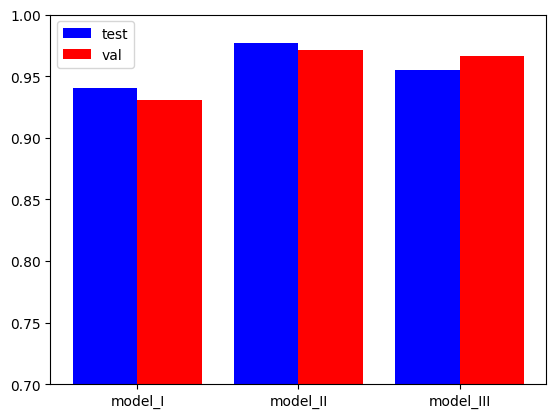

In [26]:
test_averages = [evalV1[1], evalV2[1], evalV3[1]]
val_averages = [valV1[1], valV2[1], valV3[1]]

print(test_averages)
show_data(test_averages,'test', val_averages,'val', ['model_I', 'model_II', 'model_III'])

## Evaluation

### Check the models performance on a few batches

1/1 [==============================] - 0s 94ms/step


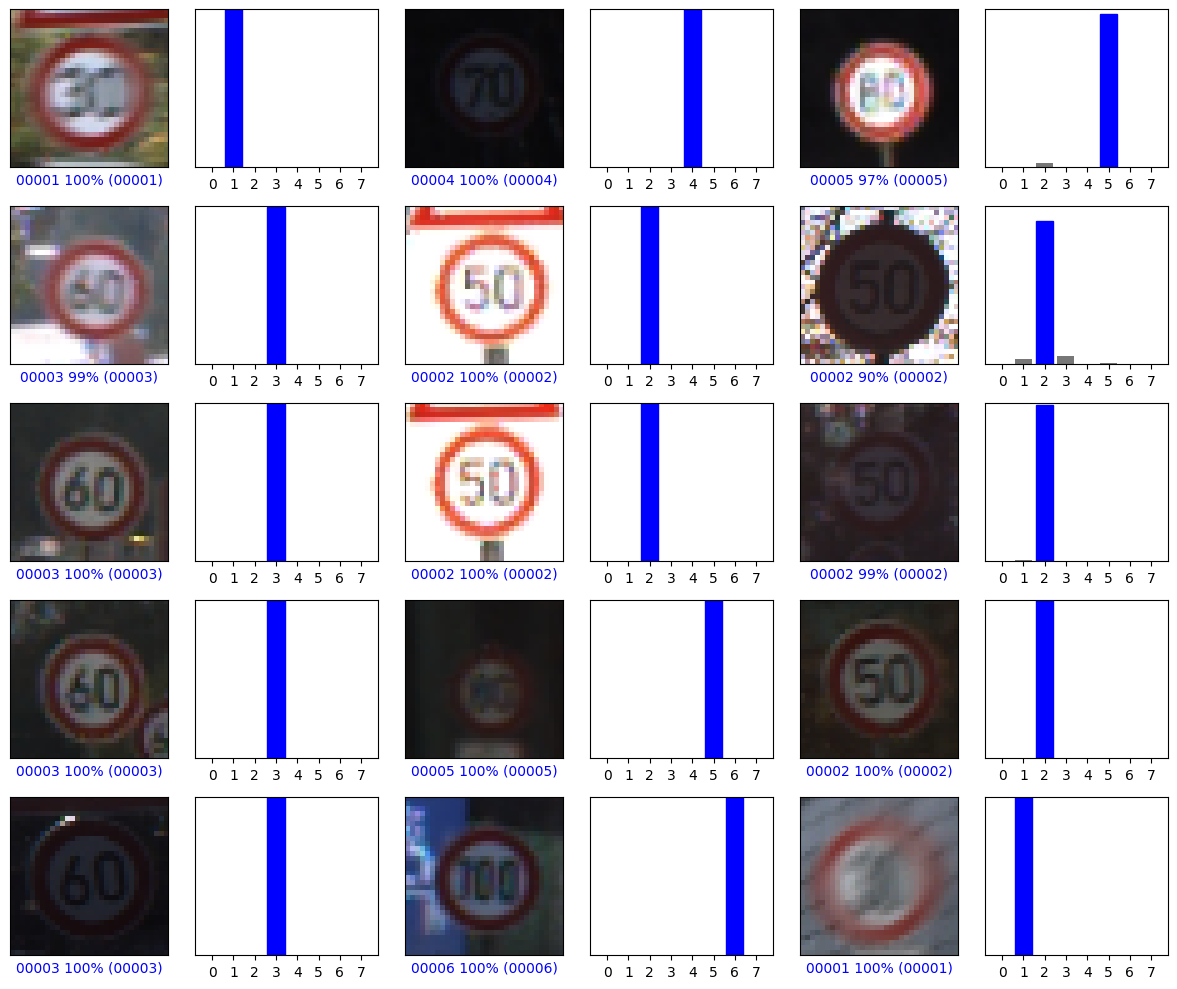

1/1 [==============================] - 0s 16ms/step


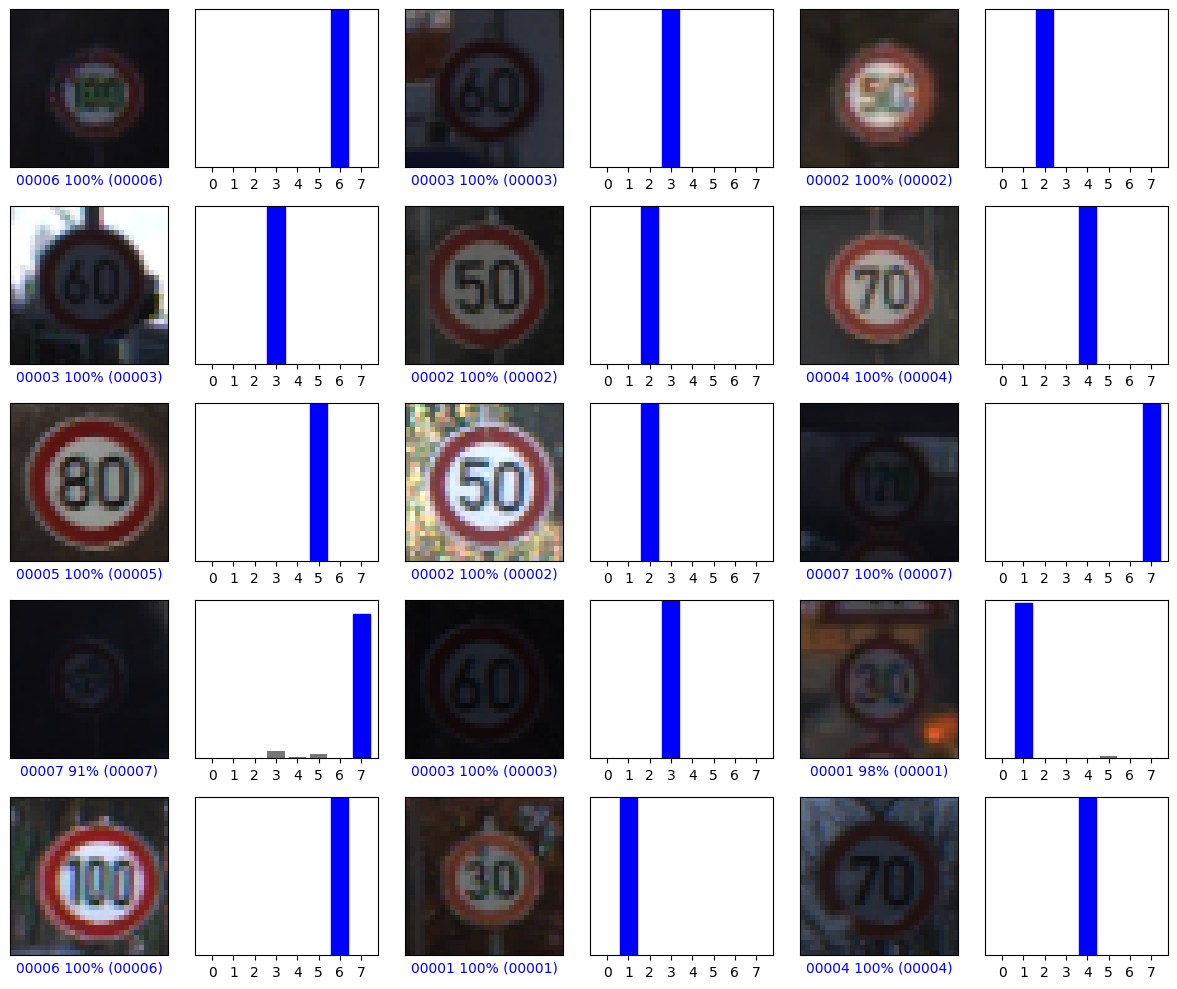

In [27]:
for images, labels in test_set.take(2):  # take n batches of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    
    preds = modelV3.predict(numpy_images)  
    plot_predictions(preds, numpy_labels, numpy_images, 5, 3)
    

### checking some misclassified images

1/1 [==============================] - 0s 19ms/step


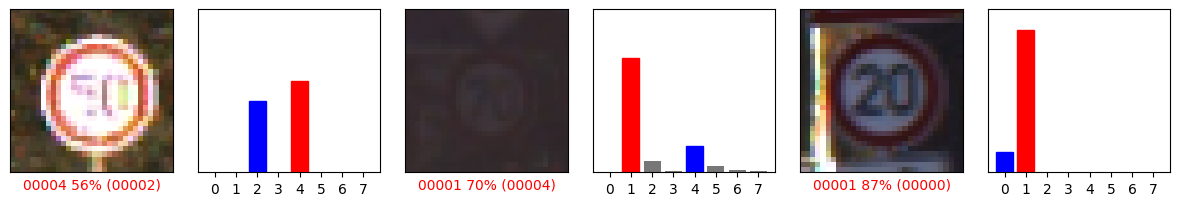

1/1 [==============================] - 0s 15ms/step


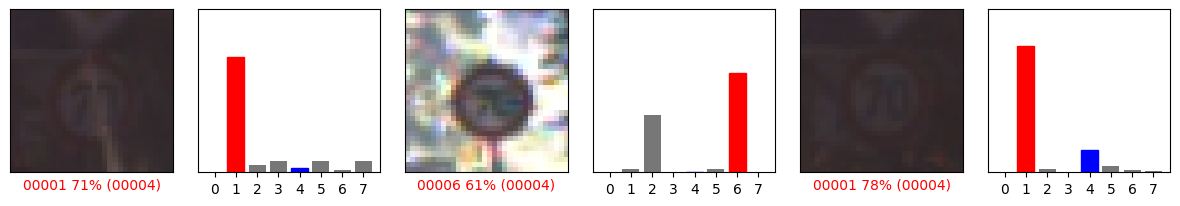

1/1 [==============================] - 0s 17ms/step


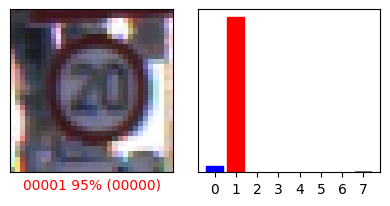

1/1 [==============================] - 0s 16ms/step


<Figure size 1200x1000 with 0 Axes>

1/1 [==============================] - 0s 18ms/step


<Figure size 1200x1000 with 0 Axes>

1/1 [==============================] - 0s 15ms/step


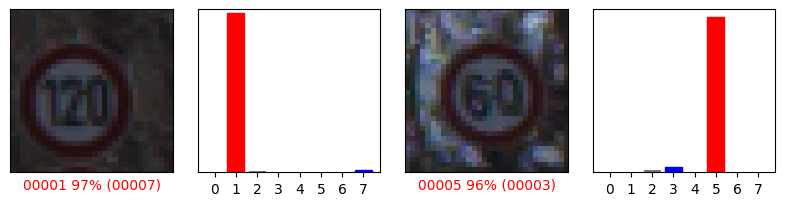

1/1 [==============================] - 0s 17ms/step


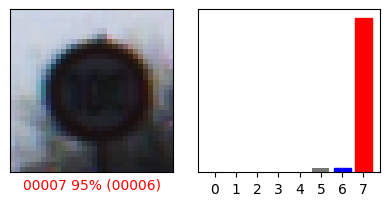

1/1 [==============================] - 0s 16ms/step


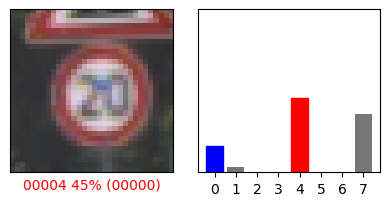

1/1 [==============================] - 0s 19ms/step


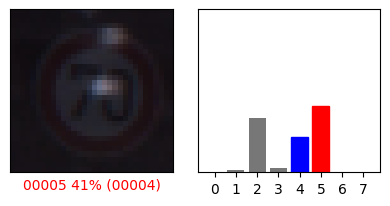

1/1 [==============================] - 0s 17ms/step


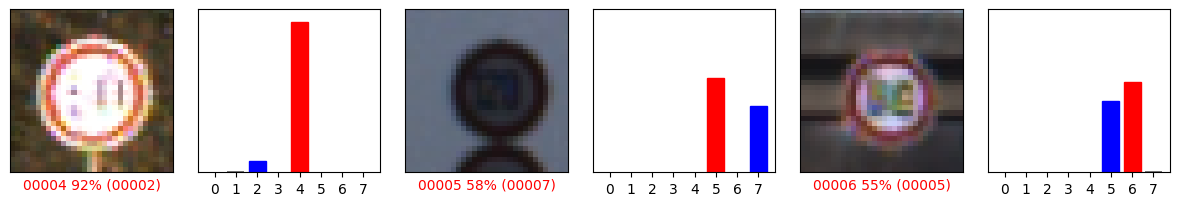

In [28]:
for images, labels in test_set.take(10):  # take 10 batches of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    
    preds = modelV3.predict(numpy_images)  
    show_misclassified(preds, numpy_labels, numpy_images, 5, 3)



### Confusion Matrix

The matrix columns represent the prediction labels and the rows represent the real labels.

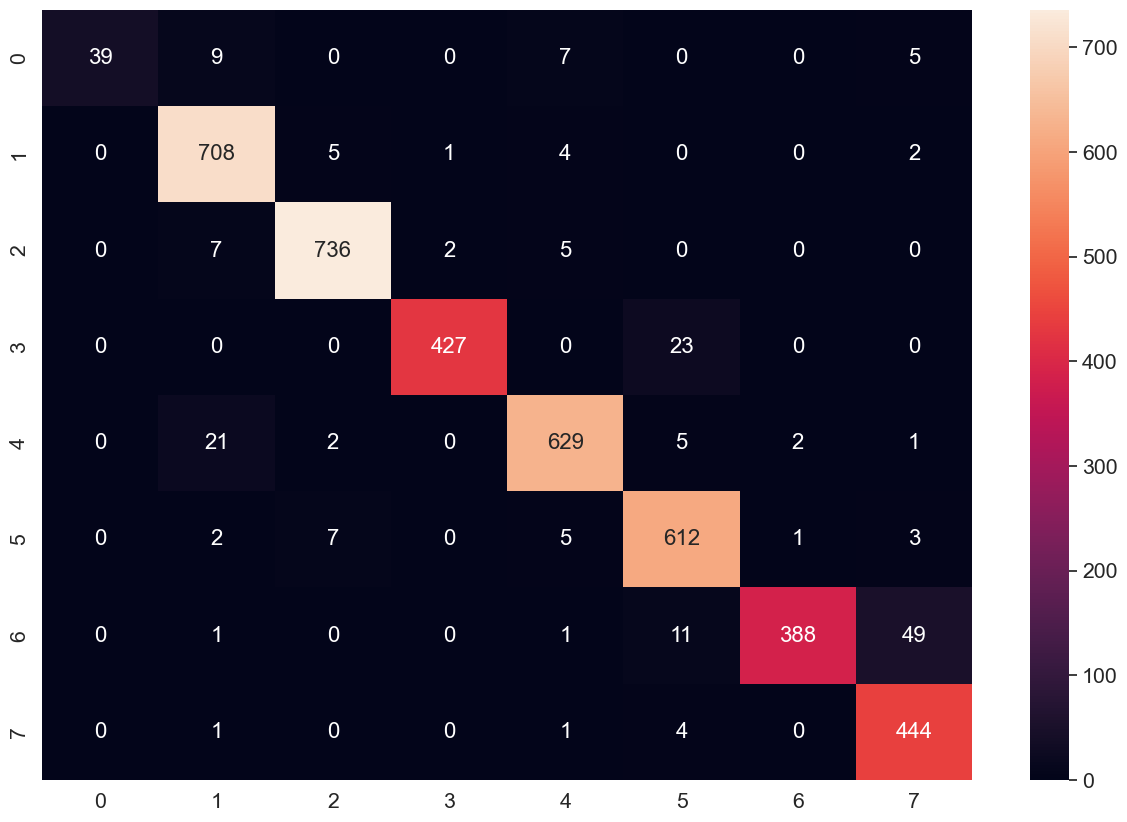

class:  0  total images:  60  % correct:  0.65
class:  1  total images:  720  % correct:  0.9833333333333333
class:  2  total images:  750  % correct:  0.9813333333333333
class:  3  total images:  450  % correct:  0.9488888888888889
class:  4  total images:  660  % correct:  0.953030303030303
class:  5  total images:  630  % correct:  0.9714285714285714
class:  6  total images:  450  % correct:  0.8622222222222222
class:  7  total images:  450  % correct:  0.9866666666666667


In [29]:
show_confusion_matrix(modelV3, test_set)